In [254]:
# Kaggle 타이타닉 문제는 타이타닉의 승객 중에 생존 유무를 예측하는 것이다.
# 아래의 코드는 https://www.kaggle.com/startupsci/titanic-data-science-solutions 를 참고해서 작성하였다.

In [255]:
# Numpy, Pandas 불러오기
import numpy as np
import pandas as pd

# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 머신러닝 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [256]:
# 데이터 불러오기
train = pd.read_csv('/python/titanic/train.csv')
test = pd.read_csv('/python/titanic/test.csv')
total = [train, test]

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
--------------------
       PassengerId      Pclass         Age       SibSp      

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

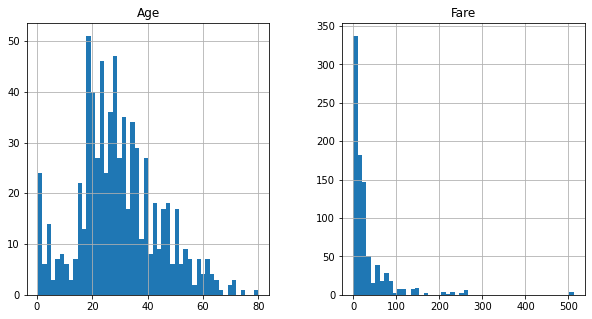

In [257]:
# 데이터 요약
print(train.describe())
print('-'*20)
print(test.describe())

# Fare에 이상치가 존재한다.
train.loc[:,['Age', 'Fare']].hist(bins=50, figsize=(10, 5))

In [258]:
# Training, Test 세트의 결측치 확인하기
# Age, Cabin, Fare, Embarked에서 결측치가 있다.
print(train.isnull().sum())
print('-'*20)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [259]:
# 카테고리형 특성들의 생존율과의 연관성을 살펴본다.
# 여기서 알수 있는 것은 여성의 생존율이 높고, 선실등급이 높을수록 생존율이 높다는 것이다.
print(train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
--------------------
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
      Sex  Survived
0  female  0.742038
1    male  0.188908


PC     60
349    53
347    48
113    47
C.A    28
       ..
C 1     1
923     1
130     1
726     1
200     1
Name: Ticket, Length: 154, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


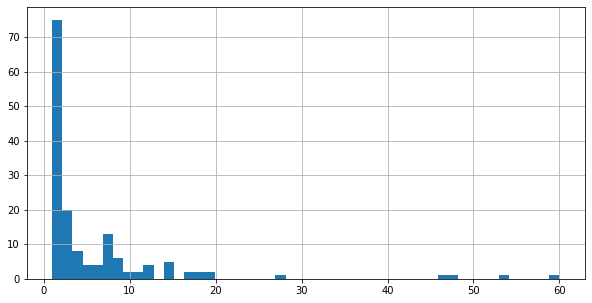

In [260]:
# 같은 번호의 Ticket을 갖는 승객과 아닌 승객과의 생존율이 연관있으므로
# Has_Same_Ticket을 생성하고 Ticket을 제거합니다.
print(train['Ticket'].apply(lambda x: x[0:3]).value_counts())
print(train['Ticket'].apply(lambda x: x[0:3]).value_counts().hist(bins=50, figsize=(10, 5)))

for data in total:
    data['Ticket'] = data['Ticket'].apply(lambda x: x[0:3])
    data['Ticket_type'] = data['Ticket'].astype('category').cat.codes
    data.drop(['Ticket'], axis=1, inplace=True)

In [261]:
print(train['Cabin'].value_counts())
print('-'*20)

# Cabin 값이 존재하면 Has_Cabin = 1, 없으면 0이다. Cabin은 삭제한다.
for data in total:
    data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    data.drop(['Cabin'], axis=1, inplace=True)

# Has_Cabin은 생존율에 연관이 있는 것으로 보인다.
print(train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
F33            3
              ..
A26            1
C82            1
D48            1
C104           1
C110           1
Name: Cabin, Length: 147, dtype: int64
--------------------
   Has_Cabin  Survived
1          1  0.666667
0          0  0.299854


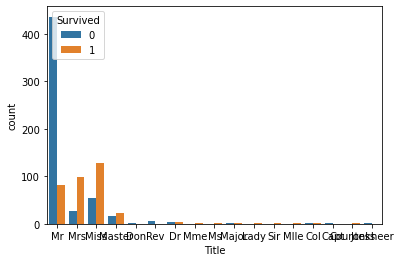

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
------------------------------
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4  Others  0.347826


In [262]:
# Name에서 Title으로 추출해서 구분한다.
for data in total:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 여성과 Master라는 Title을 가진 남성이 생존율이 높다.
sns.countplot(data=train, x='Title', hue='Survived')
plt.show()
print(pd.crosstab(train['Title'], train['Sex']))
print('-'*30)

# 희귀한 Title은 Others로 변환한다.
for data in total:
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

# Title과 생존율과의 연관성을 살펴본다.
print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

# Title을 카테고리형으로 변환하고 이후에 Name은 삭제한다.
for data in total:
    data['Title'] = data['Title'].astype('category').cat.codes
    data.drop(['Name'], axis=1, inplace=True)

   Pclass       Fare
0       1  84.154687
1       2  20.662183
2       3  13.675550


array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

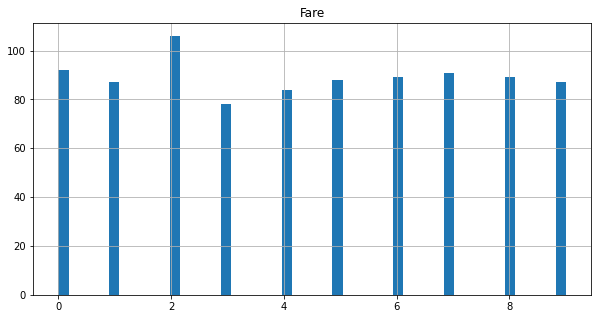

In [263]:
# Pclass, 즉 선실등급에 따른 Fare가 관련있음을 확인할 수 있다.
print(train[['Fare', 'Pclass']].groupby(['Pclass'], as_index=False).mean())

# Fare 결측치를 Pclass 기준으로 중간값을 채우고 분위수 기준으로 구간을 나눈다.
for data in total:
    data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('median'), inplace=True)
    data['Fare'] = pd.qcut(data['Fare'], 10, labels=False)

train.loc[:, ['Fare']].hist(bins=50, figsize=(10, 5))

In [264]:
# Sex를 0과 1로 나눕니다.
for data in total:
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

   Pclass        Age
0       1  38.233441
1       2  29.877630
2       3  25.140620
------------------------------
   Sex        Age
0    0  30.726645
1    1  27.915709
------------------------------
   Sex*Pclass        Age
0           3  41.281386
1           4  34.611765
2           6  30.740707
3           8  28.722973
4           9  26.507589
5          12  21.750000


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

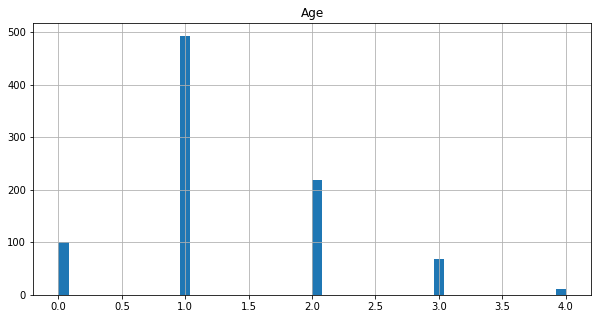

In [265]:
# Age는 Pclass와 Sex와 연관이 있는 것으로 보인다.
print(train[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean())
print('-'*30)
print(train[['Age', 'Sex']].groupby(['Sex'], as_index=False).mean())
print('-'*30)

# Sex*Pclass 특성을 추가한다.
for data in total:
    data['Sex*Pclass'] = (data['Sex'] + 3) * data['Pclass']

print(train[['Age', 'Sex*Pclass']].groupby(['Sex*Pclass'], as_index=False).mean())

# Age의 결측치를 Sex*Pclass을 기준으로 중간값으로 채운다.
for data in total:
    data['Age'].fillna(data.groupby('Sex*Pclass')['Age'].transform('median'), inplace=True)

# Sex*Pclass 특성을 제거한다.
for data in total:
    data.drop(['Sex*Pclass'], axis=1, inplace=True)

# Age를 구간을 임의로 나눠서 분류한다.
for data in total:
    data['Age'] = pd.cut(data['Age'], [0, 16, 32, 48, 64, 100], labels=False)

train.loc[:,['Age']].hist(bins=50, figsize=(10, 5))

In [266]:
# 본인이 속한 가족구성원의 수를 FamilySize에 저장한다.
for data in total:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# 가족 구성원의 수와 생존율에 연관성을 확인한다.
# 구성원이 2~4인 핵가족의 생존율이 높아보인다.
print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

# Nuclear 특성은 핵가족인 경우는 1, 아니면 0이다.
for data in total:
    data['Nuclear'] = 0
    data.loc[(2 <= data['FamilySize']) & (data['FamilySize'] <= 4), 'Nuclear'] = 1

# IsAlone는 1인 가정인 경우 1, 아니면 0이이다.
for data in total:
    data['IsAlone'] = 0
    data.loc[1 == data['FamilySize'], 'IsAlone'] = 1

# FamilySize를 제거한다.
for data in total:
    data.drop(['FamilySize', 'SibSp'], axis=1, inplace=True)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


In [267]:
# 출발항 결측치는 가장 많은 출발항 S로 채운다.
print(train['Embarked'].value_counts())
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Embarked를 카테고리 수치화한다.
for data in total:
    data['Embarked'] = data['Embarked'].astype('category').cat.codes

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [268]:
print(train.corr(method='pearson')['Survived'])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.036384
Parch          0.081629
Fare           0.323875
Embarked      -0.167675
Ticket_type   -0.168794
Has_Cabin      0.316912
Title         -0.071174
Nuclear        0.279855
IsAlone       -0.203367
Name: Survived, dtype: float64


In [269]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['PassengerId', 'Survived'], axis=1), train['Survived'], random_state=1, test_size=0.2)
X_pred = test.drop('PassengerId', axis=1).copy()

In [270]:
# 최소값을 0, 최대값을 1로 만드는 스케일링을 적용한다.
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[-1.55559305,  1.36361202,  0.76844114, ...,  1.39905549,
        -0.71531621,  0.81936653],
       [ 0.83659324, -0.73334642, -0.42356342, ...,  0.12686199,
        -0.71531621,  0.81936653],
       [-0.35949991,  1.36361202, -0.42356342, ..., -1.1453315 ,
        -0.71531621,  0.81936653],
       ...,
       [ 0.83659324, -0.73334642, -0.42356342, ...,  0.12686199,
        -0.71531621,  0.81936653],
       [ 0.83659324, -0.73334642, -0.42356342, ...,  0.12686199,
        -0.71531621,  0.81936653],
       [ 0.83659324,  1.36361202, -1.61556798, ..., -1.1453315 ,
         1.39798314, -1.22045503]])

In [271]:
# SVC
svc = SVC(random_state=1)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],\
              'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\
              'degree': [1, 2, 3, 4, 5, 6]}
grid_svc = GridSearchCV(svc, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
grid_svc.fit(X_train, y_train)
result_grid_svc = pd.DataFrame(grid_svc.cv_results_)
print(result_grid_svc[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('SVC의 그리드서치 최고 모델: {}'.format(grid_svc.best_estimator_))
print('SVC의 그리드서치 최고 파라미터: {}'.format(grid_svc.best_params_))
score_grid_svc = round(grid_svc.score(X_test, y_test) * 100, 3)
print('SVC의 테스트 세트 정확도: {}'.format(score_grid_svc))
best_score_grid_svc = round(grid_svc.best_score_ * 100, 3)
print('SVC의 그리드서치 최고 정확도: {}'.format(best_score_grid_svc))
best_grid_svc = grid_svc.best_estimator_

from sklearn.metrics import confusion_matrix, f1_score, classification_report

confusion_matrix(grid_svc.predict(X_test), y_test)
print('SVC의 f1 score: {}'.format(f1_score(grid_svc.predict(X_test), y_test)))
print(classification_report(y_test, grid_svc.predict(X_test)))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
                                         params  mean_test_score  \
0     {'C': 0.001, 'degree': 1, 'gamma': 1e-05}         0.622190   
1    {'C': 0.001, 'degree': 1, 'gamma': 0.0001}         0.622190   
2     {'C': 0.001, 'degree': 1, 'gamma': 0.001}         0.622190   
3      {'C': 0.001, 'degree': 1, 'gamma': 0.01}         0.622190   
4       {'C': 0.001, 'degree': 1, 'gamma': 0.1}         0.622190   
..                                          ...              ...   
427   {'C': 100000, 'degree': 6, 'gamma': 0.01}         0.754230   
428    {'C': 100000, 'degree': 6, 'gamma': 0.1}         0.755668   
429      {'C': 100000, 'degree': 6, 'gamma': 1}         0.698070   
430     {'C': 100000, 'degree': 6, 'gamma': 10}         0.644647   
431    {'C': 100000, 'degree': 6, 'gamma': 100}         0.644647   

     rank_test_score  
0                295  
1                295  
2                295  
3                295  
4   

In [272]:
# AdaBoost
adaboost = AdaBoostClassifier(random_state=1)
parameters = {'n_estimators': [100, 200, 500, 1000],\
              'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grid_adaboost = GridSearchCV(adaboost, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
grid_adaboost.fit(X_train, y_train)
result_grid_adaboost = pd.DataFrame(grid_adaboost.cv_results_)
print(result_grid_adaboost[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('AdaBoost의 그리드서치 최고 모델: {}'.format(grid_adaboost.best_estimator_))
print('AdaBoost의 그리드서치 최고 파라미터: {}'.format(grid_adaboost.best_params_))
score_grid_adaboost = round(grid_adaboost.score(X_test, y_test) * 100, 3)
print('Adaboost의 테스트 세트 정확도: {}'.format(score_grid_adaboost))
best_score_grid_adaboost = round(grid_adaboost.best_score_ * 100, 3)
print('AdaBoost의 그리드서치 최고 정확도: {}'.format(best_score_grid_adaboost))
best_grid_adaboost = grid_adaboost.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
                                             params  mean_test_score  \
0     {'learning_rate': 1e-05, 'n_estimators': 100}         0.789412   
1     {'learning_rate': 1e-05, 'n_estimators': 200}         0.789412   
2     {'learning_rate': 1e-05, 'n_estimators': 500}         0.789412   
3    {'learning_rate': 1e-05, 'n_estimators': 1000}         0.789412   
4    {'learning_rate': 0.0001, 'n_estimators': 100}         0.789412   
5    {'learning_rate': 0.0001, 'n_estimators': 200}         0.789412   
6    {'learning_rate': 0.0001, 'n_estimators': 500}         0.789412   
7   {'learning_rate': 0.0001, 'n_estimators': 1000}         0.789412   
8     {'learning_rate': 0.001, 'n_estimators': 100}         0.789412   
9     {'learning_rate': 0.001, 'n_estimators': 200}         0.789412   
10    {'learning_rate': 0.001, 'n_estimators': 500}         0.789412   
11   {'learning_rate': 0.001, 'n_estimators': 1000}         0.789412   
12

In [273]:
# XgBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=2000,\
                    max_depth= 4, gamma=0.9, random_state=1)
parameters = {'learning_rate': [(0.1) ** i for i in range(10)]}
grid_xgb = GridSearchCV(xgb, param_grid=parameters, cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_set= [(X_train, y_train)])
result_grid_xgb = pd.DataFrame(grid_xgb.cv_results_)
print(result_grid_xgb[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('XGB의 그리드서치 최고 모델: {}'.format(grid_xgb.best_estimator_))
print('XGB의 그리드서치 최고 파라미터: {}'.format(grid_xgb.best_params_))
score_grid_xgb = round(grid_xgb.score(X_test, y_test) * 100, 3)
print('XGB의 테스트 세트 정확도: {}'.format(score_grid_xgb))
best_score_grid_xgb = round(grid_xgb.best_score_ * 100, 3)
print('XGB의 그리드서치 최고 정확도: {}'.format(best_score_grid_xgb))
best_grid_xgb = grid_xgb.best_estimator_

[0]	validation_0-logloss:0.64137
[1]	validation_0-logloss:0.59822
[2]	validation_0-logloss:0.56258
[3]	validation_0-logloss:0.53226
[4]	validation_0-logloss:0.50649
[5]	validation_0-logloss:0.48449
[6]	validation_0-logloss:0.46564
[7]	validation_0-logloss:0.44961
[8]	validation_0-logloss:0.43513
[9]	validation_0-logloss:0.42272
[10]	validation_0-logloss:0.41188
[11]	validation_0-logloss:0.40273
[12]	validation_0-logloss:0.39383
[13]	validation_0-logloss:0.38663
[14]	validation_0-logloss:0.38002
[15]	validation_0-logloss:0.37415
[16]	validation_0-logloss:0.36963
[17]	validation_0-logloss:0.36480
[18]	validation_0-logloss:0.36058
[19]	validation_0-logloss:0.35678
[20]	validation_0-logloss:0.35308
[21]	validation_0-logloss:0.35010
[22]	validation_0-logloss:0.34753
[23]	validation_0-logloss:0.34528
[24]	validation_0-logloss:0.34295
[25]	validation_0-logloss:0.34111
[26]	validation_0-logloss:0.33954
[27]	validation_0-logloss:0.33714
[28]	validation_0-logloss:0.33375
[29]	validation_0-loglos

In [274]:
# Random Forest
random_forest = RandomForestClassifier(random_state=1)
parameters = {'max_depth': [2, 3, 4, 5, 6], 'max_features': [3, 4, 5, 6],\
              'n_estimators': [5, 10, 20, 50, 100, 200],
              'min_samples_leaf': [2, 3, 4, 5],\
              'min_samples_split': [2, 3, 4, 5]}
grid_random_forest = GridSearchCV(random_forest, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
grid_random_forest.fit(X_train, y_train)
result_grid_random_forest = pd.DataFrame(grid_random_forest.cv_results_)
print(result_grid_random_forest[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('랜덤 포레스트의 그리드서치 최고 모델: {}'.format(grid_random_forest.best_estimator_))
print('랜덤 포레스트의 그리드서치 최고 파라미터: {}'.format(grid_random_forest.best_params_))
score_grid_random_forest = round(grid_random_forest.score(X_test, y_test) * 100, 3)
print('랜덤 포레스트의 테스트 세트 정확도: {}'.format(score_grid_random_forest))
best_score_grid_random_forest = round(grid_random_forest.best_score_ * 100, 3)
print('랜덤 포레스트의 그리드서치 최고 정확도: {}'.format(best_score_grid_random_forest))
best_grid_random_forest = grid_random_forest.best_estimator_

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
                                                 params  mean_test_score  \
0     {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.787954   
1     {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.797804   
2     {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.793608   
3     {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.807633   
4     {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.807633   
...                                                 ...              ...   
1915  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.837112   
1916  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.838511   
1917  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.839939   
1918  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.839929   
1919  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.841338   

      rank_test_score 

In [275]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=1)
parameters = {'learning_rate': [(0.1) ** n for n in range(10)],\
              'n_estimators': np.arange(10, 3000, 10),\
              'max_depth': np.arange(1, 10, 1),\
              'max_features': np.arange(1, 5, 1),\
              'min_samples_leaf': np.arange(1, 10, 1),\
              'min_samples_split': np.arange(2, 10, 1),\
              }
random_gbc = RandomizedSearchCV(gbc, n_iter=300, param_distributions=parameters, cv=5, verbose=2, n_jobs=-1, refit=True)
random_gbc.fit(X_train, y_train)
result_random_gbc = pd.DataFrame(random_gbc.cv_results_)
print(result_random_gbc[['params', 'mean_test_score', 'rank_test_score'\
                 ]])
print('GBC의 랜덤서치 최고 모델: {}'.format(random_gbc.best_estimator_))
print('GBC의 랜덤서치 최적 파라미터: {}'.format(random_gbc.best_params_))
score_random_gbc = round(random_gbc.score(X_test, y_test) * 100, 3)
print('GBC의 테스트 세트 정확도: {}'.format(score_random_gbc))
best_score_random_gbc = round(random_gbc.best_score_ * 100, 3)
print('GBC의 랜덤서치 최고점수: {}'.format(best_score_random_gbc))
best_random_gbc = random_gbc.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
                                                params  mean_test_score  \
0    {'n_estimators': 1250, 'min_samples_split': 3,...         0.622190   
1    {'n_estimators': 2390, 'min_samples_split': 4,...         0.838511   
2    {'n_estimators': 2020, 'min_samples_split': 7,...         0.622190   
3    {'n_estimators': 720, 'min_samples_split': 4, ...         0.622190   
4    {'n_estimators': 80, 'min_samples_split': 3, '...         0.688171   
..                                                 ...              ...   
295  {'n_estimators': 1850, 'min_samples_split': 4,...         0.622190   
296  {'n_estimators': 1680, 'min_samples_split': 5,...         0.830090   
297  {'n_estimators': 630, 'min_samples_split': 6, ...         0.622190   
298  {'n_estimators': 1600, 'min_samples_split': 3,...         0.830050   
299  {'n_estimators': 260, 'min_samples_split': 8, ...         0.622190   

     rank_test_score  
0           

In [276]:
# Multilayer Perceptron
mlp = MLPClassifier(random_state=1)
parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'],\
              'solver': ['lbfgs', 'adam', 'sgd'],\
              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
grid_mlp = GridSearchCV(mlp, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
grid_mlp.fit(X_train, y_train)
result_grid_mlp = pd.DataFrame(grid_mlp.cv_results_)
print(result_grid_mlp[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('MLP의 그리드서치 최고 모델: {}'.format(grid_mlp.best_estimator_))
print('MLP의 그리드서치 최고 파라미터: {}'.format(grid_mlp.best_params_))
score_grid_mlp = round(grid_mlp.score(X_test, y_test) * 100, 3)
print('MLP의 테스트 세트 정확도: {}'.format(score_grid_mlp))
best_score_grid_mlp = round(grid_mlp.best_score_ * 100, 3)
print('MLP의 그리드서치 최고 정확도: {}'.format(best_score_grid_mlp))
best_grid_mlp = grid_mlp.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
                                               params  mean_test_score  \
0   {'activation': 'identity', 'alpha': 1e-05, 'so...         0.814646   
1   {'activation': 'identity', 'alpha': 1e-05, 'so...         0.797804   
2   {'activation': 'identity', 'alpha': 1e-05, 'so...         0.613602   
3   {'activation': 'identity', 'alpha': 0.0001, 's...         0.817453   
4   {'activation': 'identity', 'alpha': 0.0001, 's...         0.797804   
5   {'activation': 'identity', 'alpha': 0.0001, 's...         0.683906   
6   {'activation': 'identity', 'alpha': 0.001, 'so...         0.816064   
7   {'activation': 'identity', 'alpha': 0.001, 'so...         0.797804   
8   {'activation': 'identity', 'alpha': 0.001, 'so...         0.678410   
9   {'activation': 'identity', 'alpha': 0.01, 'sol...         0.817463   
10  {'activation': 'identity', 'alpha': 0.01, 'sol...         0.797804   
11  {'activation': 'identity', 'alpha': 0.01, 'sol

In [277]:
# Decision Tree
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5,\
                         max_features=5, min_samples_leaf=5, random_state=1)
decision_tree.fit(X_train, y_train)
score_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 3)
print('결정 트리의 테스트 세트 정확도: {}'.format(score_decision_tree))

# Perceptron
perceptron = Perceptron(random_state=1)
perceptron.fit(X_train, y_train)
score_perceptron = round(perceptron.score(X_test, y_test) * 100, 3)
print('Perceptron의 테스트 세트 정확도: {}.'.format(score_perceptron))

# GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
score_gnb = round(gnb.score(X_test, y_test) * 100, 3)
print('GaussainNB의 테스트 세트 정확도: {}'.format(score_gnb))

# Logistic Regression
logreg = LogisticRegression(max_iter=2000, random_state=1)
logreg.fit(X_train, y_train)
score_logreg = round(logreg.score(X_test, y_test) * 100, 3)
print('로지스틱회귀의 테스트 세트 정확도: {}'.format(score_logreg))

# Linear SVC
linear_svc = LinearSVC(max_iter=10000, random_state=1)
linear_svc.fit(X_train, y_train)
score_linear_svc = round(linear_svc.score(X_test, y_test) * 100, 3)
print('LinearSVC의 테스트 세트 정확도: {}'.format(score_linear_svc))

# K-Neighbors Classfier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
score_knn = round(knn.score(X_test, y_test) * 100, 3)
print('KNN의 테스트 세트 정확도: {}'.format(score_knn))

# Stochastic Gradient Decent
sgd = SGDClassifier(random_state=1)
sgd.fit(X_train, y_train)
score_sgd = round(sgd.score(X_test, y_test) * 100, 3)
print('SGD의 테스트 세트 정확도: {}'.format(score_sgd))

결정 트리의 테스트 세트 정확도: 76.536
Perceptron의 테스트 세트 정확도: 64.246.
GaussainNB의 테스트 세트 정확도: 67.598
로지스틱회귀의 테스트 세트 정확도: 80.447
LinearSVC의 테스트 세트 정확도: 80.447
KNN의 테스트 세트 정확도: 71.508
SGD의 테스트 세트 정확도: 70.95
C:\Users\darkzard05\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [278]:
# 머신러닝 모델 중에 가장 높은 교차검증 점수를 갖는 모델을 선택한다.
models = pd.DataFrame([['Perceptron', score_perceptron, perceptron],\
                      ['GaussianNB', score_gnb, gnb], ['KNN', score_knn, knn],\
                      ['Random Forest', score_grid_random_forest,\
                        best_grid_random_forest],\
                      ['Decision Tree', score_decision_tree,\
                        decision_tree],\
                      ['Gradient Boosting Classifier', score_random_gbc,\
                        best_random_gbc],\
                      ['MLP', score_grid_mlp, best_grid_mlp],\
                      ['Linear SVC', score_linear_svc, linear_svc],\
                      ['Stochastic Gradient Decent', score_sgd, sgd],\
                      ['Logistic Regression', score_logreg, logreg],\
                      ['SVC', score_grid_svc, best_grid_svc],\
                      ['AdaBoost', score_grid_adaboost, best_grid_adaboost],\
                      ['XGB', score_grid_xgb, best_grid_xgb]],\
                    columns=['Model', 'Score', 'Estimator'])
sorted_models = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Model','Score']]
best_estimator = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Estimator','Score']]
print(sorted_models)
print('-' * 40)
print('테스트 세트 정확도가 가장 높은 모델은 {}이고 점수는 {}이다'.format(sorted_models.iloc[0, 0], sorted_models.iloc[0, 1]))
Y_pred = best_estimator.iloc[0, 0].predict(X_pred)

                           Model   Score
0                       AdaBoost  81.006
1                     Linear SVC  80.447
2            Logistic Regression  80.447
3   Gradient Boosting Classifier  79.330
4                            XGB  79.330
5                  Random Forest  78.212
6                            MLP  78.212
7                            SVC  77.654
8                  Decision Tree  76.536
9                            KNN  71.508
10    Stochastic Gradient Decent  70.950
11                    GaussianNB  67.598
12                    Perceptron  64.246
----------------------------------------
테스트 세트 정확도가 가장 높은 모델은 AdaBoost이고 점수는 81.006이다


In [279]:
# 결과를 CSV로 저장한다.
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submission.to_csv('C:/python/titanic/submission.csv', index=False)